In [1]:
import numpy as np
import math

import pandas as pd   # csvファイルを読み込み、ndarrayに変換するために必要なる。

# 冷蔵庫　JIS C 9801：1999準拠APF

## 1. 定義

冷蔵庫　JIS C 9801:1999準拠APFは、APFをJIS C 9801:1999で測定した家庭用冷蔵庫である。  
家庭用冷蔵庫は「　　」である。

## 2. 年間消費電力量

年間消費電量$E_{ elc, y }$は年開始日から年終了日までの時刻別消費電力量の積算値である。

$$
E_{ elc, y } = \sum_{ d = 1 }^{ 365 } \sum_{ t = 1 }^{ 24 } E_{ elc, d, t }
$$

$E_{ elc, y }$ :年間(<u>y</u>early)消費電力量(<u>ele</u>ctric <u>E</u>nergy) [Wh]  
$E_{ elc, d, t }$ :$d$日$t$時の消費電力量 [Wh]  

In [2]:
def calc_E_elc_y(theta_ext_d, Q, central_heating_exists, APF, P_elc_htr_rtd, R_rfrg_d_t, R_dfrs_d_t):
    """時刻別消費電力量から年間消費電力量を計算する
    
    Parameters
    ----------
    theata_ext_d : ndarray(N-dimensional array)
        日別の平均外気温度[℃]を格納したND配列
        d日の平均外気温度[℃]が年開始日から365個連続して格納されている
    
    Q : float
        住宅の熱損失係数 [W/(m^2・K)] 
    
    central_heating_exists : bool
        住宅の暖房方式（True:全館連続暖房, False:居室間歇暖房）
        
    APF : float
        通年エネルギー消費効率(APF = Annual Perfromance Factor)
    
    P_elc_htr_rtd : float
        除霜用電熱器の定格消費電力[W]
        
    R_rfrg_d_t : ndarray(N-dimensional array)
        冷蔵の時刻別占有率を格納したND配列
        d日t時の冷蔵の占有率[-]が年開始時から8760個連続して格納されている

    R_dfrs_d_t : ndarray(N-dimensional array)
        除霜の時刻別占有率を格納したND配列
        d日t時の除霜の占有率[-]が年開始時から8760個連続して格納されている
    
    Returns
    ----------
    E_elc_y : float
        年間消費電力量[Wh]
    """
    
    # 時刻別消費電力量を計算する
    E_elc_d_t = calc_E_elc_d_t(theta_ext_d, Q, central_heating_exists, APF, P_elc_htr_rtd, R_rfrg_d_t, R_dfrs_d_t)
    
    # 年間費電力量を計算する
    E_elc_y = np.sum(E_elc_d_t)
    
    return E_elc_y

## 3. 時刻別消費電力量

時刻別消費電力量$E_{ elc, d, t }$  は冷蔵電力$P_{ rfrg, d, t }$に1時間当たりの冷蔵使用率$R_{ rfrg, d, t }$を掛けた値とと除霜電力$P_{ dfrs, d, t }$に1時間当たりの除霜使用率$R_{ dfrs, d, t }$を掛けた値の合計値である。

$$
E_{ elc, d, t } = P_{ rfrg, d, t } \times R_{ rfrg, d, t } + P_{ dfrs, d, t } \times R_{ dfrs, d, t }
$$

$P_{ rfrg, d, t }$ :$d$日$t$時の冷蔵電力 [W]  
$R_{ rfrg, d, t }$ :$d$日$t$時における冷蔵の占める割合 [-]  
$P_{ dfrs, d, t }$ :$d$日$t$時の除霜電力 [W]  
$R_{ dfrs, d, t }$ :$d$日$t$時における除霜の占める割合 [-]  

In [3]:
def calc_E_elc_d_t(theta_ext_d, Q, central_heating_exists, APF, P_elc_htr_rtd, R_rfrg_d_t, R_dfrs_d_t):
    """時刻別消費電力量を計算する
    
    Parameters
    ----------
    theata_ext_d : ndarray(N-dimensional array)
        日別の平均外気温度[℃]を格納したND配列
        d日の平均外気温度[℃]が年開始日から365個連続して格納されている
    
    Q : float
        住宅の熱損失係数 [W/(m^2・K)] 
    
    central_heating_exists : bool
        住宅の暖房方式（True:全館連続暖房, False:居室間歇暖房）
        
    APF : float
        通年エネルギー消費効率(APF = Annual Perfromance Factor)
    
    P_elc_htr_rtd : float
        除霜用電熱器の定格消費電力[W]
        
    R_rfrg_d_t : ndarray(N-dimensional array)
        冷蔵の時刻別占有率を格納したND配列
        d日t時の冷蔵の占有率[-]が年開始時から8760個連続して格納されている

    R_dfrs_d_t : ndarray(N-dimensional array)
        除霜の時刻別占有率を格納したND配列
        d日t時の除霜の占有率[-]が年開始時から8760個連続して格納されている
    
    Returns
    ----------
    E_elc_d_t : ndarray(N-dimensional array)
        1年間の全時間の消費電力量[Wh]を格納したND配列
        d日t時の消費電力[W]が年開始時から8760個連続して格納されている
    """
    
    # 冷蔵の時刻別電力を計算する
    P_elc_rfrg_d_t = calc_P_elc_rfrg_d_t(theta_ext_d, Q, central_heating_exists, APF, P_elc_htr_rtd)

    # 除霜の時刻別電力を取得する（計算calcと取得getの定義を再確認する->2019.04.04打ち合わせ）
    P_elc_dfrs_d_t = get_P_elc_dfrs_d_t(P_elc_htr_rtd)
    
    # 冷蔵庫の時刻別消費電力を計算する
    E_elc_d_t = P_elc_rfrg_d_t * R_rfrg_d_t + P_elc_dfrs_d_t * R_dfrs_d_t
    
    return E_elc_d_t

## 4. 電力

### 4.1. 冷蔵の時刻別電力

$d$日$t$時の冷蔵電力$P_{ elc, rfrg, d, t }$は$d$日の冷蔵庫の推定消費電力量$E_{ elc, rfrg, est, d }$から除霜運転の消費電力量を引いた値を冷蔵運転時間で除した値である。  
ただし、1日当たりの除霜運転は2時間とする。

$$
P_{ elc, rfrg, d, t } = \frac{ E_{ elc, rfrg, est, d } - P_{ elc, dfrs, d, t } \times hr_{ dfrs }}{ 24 - hr_{ dfrs } }  
$$  

$E_{elc,est,d}$ :$d$日の冷蔵庫の推定(<u>est</u>imated)消費電力量 [Wh/d]  
$hr_{dfrs}$ :1日当たりの除霜運転の時間 (= 2) [h/d]  

ここで、$d$日の1日当たりの冷蔵庫の推定消費電力量$E_{elc,est,d}$は冷蔵庫の年間消費電力量と冷蔵庫周辺空気の日平均温度を説明変数とした推定値である。 

$$
E_{ elc, rfrg, est, d } = [(3.283 \times 10^{-3} -2.0 \times 10^{-6} \times APF)
\times (\theta_{ amb, est, d }^{2} - 30 \times \theta_{ amb, est, d }) + 1.85 \times 10^{-3} \times APF + 1.329 ] \times 10^{3}
$$  


$APF$ :通年エネルギー消費効率[-]  
$\theta_{ amb, est, d }$ :$d$日の冷蔵庫周辺空気(<u>amb</u>ient air)の推定温度 [℃]  

ただし、$d$日の冷蔵庫周辺空気の推定温度は日平均外気温度$\theta_{ext,d}$と住宅の熱損失係数$Q$を説明変数とした推定値とする。  

$$
\theta_{ amb, est, d } =
\begin{cases}
(0.0480 \times Q + 0.3666) \times \theta_{ ext, d } + (-1.2435 \times Q + 18.82) & ,居室間歇暖房時 \\
(0.0604 \times Q + 0.3668) \times \theta_{ ext, d } + (-1.6265 \times Q + 19.99) & ,全館連続暖房時 \\
\end{cases}
$$

$\theta_{ ext, d }$ :$d$日の日平均外気(<u>ext</u>ernal air)温度 [℃]  
$Q$ :住宅の熱損失係数 [W/(m<sup>2</sup>・K)]  



In [4]:
def calc_P_elc_rfrg_d_t(theta_ext_d, Q, central_heating_exists, APF, P_elc_htr_rtd):
    """冷蔵の時刻別電力を計算する
    
    Parameters
    ----------
    theata_ext_d : ndarray(N-dimensional array)
        日別の平均外気温度[℃]を格納したND配列
        d日の平均外気温度[℃]が年開始日から365個連続して格納されている
    
    Q : float
        住宅の熱損失係数 [W/(m^2・K)] 
    
    central_heating_exists : bool
        住宅の暖房方式（True:全館連続暖房, False:居室間歇暖房）
        
    APF : float
        通年エネルギー消費効率(APF = Annual Perfromance Factor)
    
    P_elc_htr_rtd : float
        除霜用電熱器の定格消費電力[W]
    
    Returns
    ----------
    P_rfrg_d_t : ndarray(N-dimensional array)
        冷蔵の時刻別電力[W]を格納したND配列
        d日t時の電力[W]が年開始時から8760個連続して格納されている
    """
    
    # 冷蔵の日別推定消費電力量を取得する
    theta_amb_est_d = get_theta_amb_est_d(theta_ext_d, Q, central_heating_exists) # theta_amb_est_dを求める過程で暖房方式が指定されるのは、現時点では仕方ないが、煩雑に思われる。  
    E_elc_rfrg_est_d = get_E_elc_rfrg_est_d(APF, theta_amb_est_d) # 冷蔵庫の推定消費電力はJIS基準での1日別消費電力に直すべき。
    
    # 除霜の時刻別電力を取得する
    P_elc_dfrs_d_t = get_P_elc_dfrs_d_t(P_elc_htr_rtd)
    
    HOURS_OF_DEFROST = 2 # 1日当たりの除霜運転の時間[h/d]

    # 冷蔵の時刻別電力を計算する
    P_elc_rfrg_d_t = np.zeros(8760)
    
        # forを使わずに済む方法はないだろうか？（2019.04.03 峰野＠AES）
    for d in range(365):
        for h in range(24):
            i = d *24 + h
            P_elc_rfrg_d_t[i] =  (E_elc_rfrg_est_d[d] - P_elc_dfrs_d_t[i] * HOURS_OF_DEFROST) / (24 - HOURS_OF_DEFROST)

    return P_elc_rfrg_d_t

In [5]:
def get_theta_amb_est_d(theta_ext_d, Q, central_heating_exists):
    """冷蔵庫周辺空気の推定空気温度を取得する
    
    Parameters
    ----------
    theata_ext_d : ndarray(N-dimensional array)
        日別の平均外気温度[℃]を格納したND配列
        d日の平均外気温度[℃]が年開始日から365個連続して格納されている
    
    Q : float
        住宅の熱損失係数 [W/(m^2・K)] 
    
    central_heating_exists : bool
        住宅の暖房方式（True:全館連続暖房, False:居室間歇暖房）
    
    Returns
    ----------
    theata_amb_est_d : ndarray(N-dimensional array)
        日別の冷蔵庫周辺空気の推定温度[℃]を格納したND配列
        d日の冷蔵庫周辺空気の推定温度[℃]が年開始日から365個連続して格納されている
    """
    # 冷蔵庫周辺空気を暖房方式別に推定する
    if central_heating_exists == False: # 居室間歇暖房
        theta_amb_est_d = (0.0480 * Q + 0.3666) * theta_ext_d + (-1.2435 * Q + 18.82)
    else: # 全館連続暖房
        theta_amb_est_d = (0.0604 * Q + 0.3668) * theta_ext_d + (-1.6265 * Q + 19.99)
    
    return theta_amb_est_d

In [6]:
def get_E_elc_rfrg_est_d(APF, theta_amb_est_d):
    """冷蔵の日別推定消費電力量を取得する
    
    Parameters
    ----------
    APF : float
        通年エネルギー消費効率(APF = Annual Perfromance Factor)
        
    theata_amb_est_d : ndarray(N-dimensional array)
        日別の冷蔵庫周辺空気の推定温度[℃]を格納したND配列
        d日の冷蔵庫周辺空気の推定温度[℃]が年開始日から365個連続して格納されている
    
    Returns
    ----------
    E_elc_rfrg_est_d : ndarray(N-dimensional array)
        冷蔵の日別推定消費電力量[Wh]を格納したND配列
        d日の冷蔵の推定消費電力量[Wh]が年開始日から365個連続して格納されている
        
    """
    
    # 冷蔵の日別電力を推定する
    E_elc_rfrg_est_d_kWh = (3.283 * 10**(-3) - 2.0 * 10**(-6) * APF) * (theta_amb_est_d**2 - 30 * theta_amb_est_d) \
                         + 1.85 * 10**(-3) * APF \
                         + 1.329
    E_elc_rfrg_est_d = E_elc_rfrg_est_d_kWh * 10**(3)
    
    return E_elc_rfrg_est_d

### 4.2. 除霜の時刻別消費電力

$d$日$t$時の除霜電力$P_{ elc, dfrs, d, t }$は除霜用伝熱器の消費電力$P_{ elc, htr }$に補正係数$C_{ crct, htr }$を掛けた値である。
 
$$
P_{ elc, dfrs, d, t} = P_{ elc, htr, rtd} \times C_{ crct, htr }
$$
  
$P_{ elc, htr, rtd }$ :除霜用電熱器(<u>h</u>ea<u>t</u>e<u>r</u>)の定格(<u>r</u>a<u>t</u>e<u>d</u>)消費電力 [W]  
$C_{ crct, htr }$ :除霜用電熱器の定格消費電力に対する補正係数(<u>c</u>o<u>rr</u>e<u>ct</u>ion <u>c</u>oefficient) (=0.9) [-]  

In [7]:
def get_P_elc_dfrs_d_t(P_elc_htr_rtd):
    """除霜の時刻別電力を取得する
    
    Parameters
    ----------
    P_elc_htr_rtd : float
        除霜用電熱器の定格消費電力[W]
    
    Returns
    ----------
    P_dfrs_d_t : ndarray(N-dimensional array)
        除霜の時刻別消費電力[W]を格納したND配列
        d日t時の除霜の消費電力[W]が年開始時から8760個連続して格納されている
        
    """
    # 除霜の時刻別電力を計算する
    CORRECTION_COEFFICIENT_OF_HEATER = 0.9 # 除霜用電熱器の定格消費電力に対する補正係数[-]
    P_elc_dfrs_d_t = np.full(8760, P_elc_htr_rtd * CORRECTION_COEFFICIENT_OF_HEATER, dtype=float)
    return P_elc_dfrs_d_t

## 5. 稼働状態の時刻別占有率

冷蔵庫の稼働状態の時刻別占有率はスケジュールにより定まる。  
冷蔵庫の取りうる稼働状態を以下に示す。各時刻においてこれら占有率の総和は常に1となる。

### 5.1.   冷蔵の時刻別占有率

$d$日$t$時における冷蔵の占める割合$R_{ rfrg, d, t }$はスケジュールにより定まる。

### 5.2.   除霜の時刻別占有率

$d$日$t$時における除霜の占める割合$R_{ dfrs, d, t }$はスケジュールにより定まる。

## ex. 1.   計算例

### ex. 1.1.  外部ファイルからの読み込み

計算に必要なパラメータを外部ファイルから読み込む

#### ex. 1.1.1.  日平均外気温度

In [8]:
def import_theta_ext_d():
    """日平均外気温度を外部CSVファイルからND配列に読み込む
    
    Returns
    ----------
    theta_ext_d : ndarray(N-dimensional array)
        日平均外気温度を格納したND配列
        d日の日平均外気温度[℃]が年開始日から365個連続して格納されている
        
    """
    
    df = pd.read_csv('external_air_temperature_sample.csv', encoding='SHIFT_JIS')
    ds = df['日平均外気温度[℃]']
    theta_ext_d = ds.values
    return theta_ext_d

#### ex. 1.1.2.  冷蔵の時刻別占有率

In [9]:
def import_R_rfrg_d_t():
    """冷蔵の時刻別占有率を外部CSVファイルからND配列に読み込む
    
    Returns
    ----------
    R_rfrg_d_t : ndarray(N-dimensional array)
        冷蔵の時刻別占有率を格納したND配列
        d日t時の冷蔵の占有率[-]が年開始時から8760個連続して格納されている
        
    """
    
    df = pd.read_csv('occupancy_sample.csv', encoding='SHIFT_JIS')
    ds = df['冷蔵の占有率[-]']
    R_rfrg_d_t = ds.values
    return R_rfrg_d_t

#### ex. 1.1.3.  除霜の時刻別占有率

In [10]:
def import_R_dfrs_d_t():
    """除霜の時刻別占有率を外部CSVファイルからND配列に読み込む
    
    Returns
    ----------
    R_dfrs_d_t : ndarray(N-dimensional array)
        除霜の時刻別占有率を格納したND配列
        d日t時の除霜の占有率[-]が年開始時から8760個連続して格納されている
        
    """
    
    df = pd.read_csv('occupancy_sample.csv', encoding='SHIFT_JIS')
    ds = df['除霜の占有率[-]']
    R_dfrs_d_t = ds.values
    return R_dfrs_d_t

### ex. 1.2. 一括計算

In [11]:
def calc_E_elc(Q, central_heating_exists, APF, P_elc_htr_rtd):
    """消費電力量を計算する
    
    Parameters
    ----------
    Q : float
        住宅の熱損失係数 [W/(m^2・K)] 
    
    central_heating_exists : bool
        住宅の暖房方式（True:全館連続暖房, False:居室間歇暖房）
        
    APF : float
        通年エネルギー消費効率(APF = Annual Perfromance Factor)
    
    P_elc_htr_rtd : float
        除霜用電熱器の定格消費電力[W]

    
    Returns
    ----------
    E_elc_y : float
        年間消費電力量[Wh]
    E_elc_h : ndarray(N-dimensional array)
        時刻別消費電力量[Wh]   
    """
    
    # 外部ファイルからパラメーターを取得する
    theta_ext_d = import_theta_ext_d()
    R_rfrg_d_t = import_R_rfrg_d_t()
    R_dfrs_d_t = import_R_dfrs_d_t()
    
    # 計算開始
    E_elc_h = calc_E_elc_d_t(theta_ext_d, Q, central_heating_exists, APF, P_elc_htr_rtd, R_rfrg_d_t, R_dfrs_d_t)
    E_elc_y = np.sum(E_elc_h)
    return E_elc_y, E_elc_h

## ex. 2. 動作確認

動作確認用に計算結果を図示する。

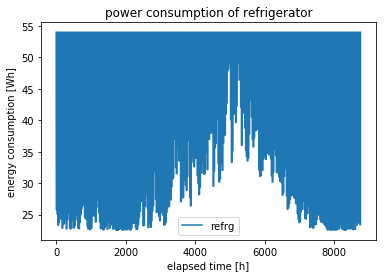

In [12]:
import matplotlib.pyplot as plt

res = calc_E_elc( 2.0, False, 6.0, 60)

E_elc_y = res[0]
E_elc_d_t = res[1]

x = np.arange(8760)
y = E_elc_d_t

plt.plot(x, y, label='refrg')
plt.title('power consumption of refrigerator')
plt.xlabel('elapsed time [h]')
plt.ylabel('energy consumption [Wh]')
plt.legend()

plt.show()